# Prediction Models for Used Car Values

The Rusty Bargain used car sales service wishes to develop an app to attract new customers. In that app, customers will quickly be able to find out the market value of their car. 

We have access to historical data (technical specifications, trim versions, and prices) and we will build models to determine the market values. 

The company is interested in the following:

- the quality of the prediction
- the speed of the prediction
- the time required for training.

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from timeit import default_timer as timer
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Data Preparation

Importing and investigating the data:

In [2]:
try:
    data = pd.read_csv('/datasets/car_data.csv')
except:
    data = pd.read_csv('/Users/Steve Lewis/practicum_datasets/car_data.csv')

In [3]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


There are 354369 rows of data and 16 columns (variables).

As stated at the outset, the job is to build and compare models that predict the market value (ie the 'expected price') of a car. 

From the information above it can immediately be seen that there are three 'date' columns in the dataset that will not be useful as features for our models, so I will immediately drop them from the dataset.

I will also drop the 'PostalCode' column as it is assumed that the postal code of the seller will not affect the price of the car being sold.

In [5]:
columns_to_drop = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode']

In [6]:
data = data.drop(columns = columns_to_drop)

In [7]:
data.shape

(354369, 12)

These 4 columns have been successfully dropped.

In the above, it was also clear that the dataset contains missing values.  These will now be examined further: 

In [8]:
data.isnull().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
NumberOfPictures         0
dtype: int64

In [9]:
100*data.isnull().sum().sort_values(ascending = False)/len(data)

NotRepaired          20.079070
VehicleType          10.579368
FuelType              9.282697
Gearbox               5.596709
Model                 5.560588
NumberOfPictures      0.000000
Brand                 0.000000
RegistrationMonth     0.000000
Mileage               0.000000
Power                 0.000000
RegistrationYear      0.000000
Price                 0.000000
dtype: float64

5 columns have missing values.  The column with the largest amount is 'NotRepaired' where over 20% are missing, followed by 'VehicleType' where 10.57% are missing.

In [10]:
data.dtypes

Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Mileage               int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
NumberOfPictures      int64
dtype: object

The 5 columns with missing values are all of the 'object' datatype.  We will replace the null values with 'unknown':

In [11]:
data = data.fillna('unknown')

In [12]:
data.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
NumberOfPictures     0
dtype: int64

The missing values have successfully been removed.  

Now I investigate the distribution of the numeric columns:

In [13]:
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0


The following have been discovered:

1. There are some errors in the 'RegistrationYear' column, with dates as low as 1000 and as high as 9999; the rows with the infeasible dates will be deleted
2. The maximum 'Power' is infeasibly large; such extreme outliers will also be deleted 
3. The minimum 'RegistrationMonth' should be 1 (corresponding to January), not zero
4. There is no useful information in the 'NumberOfPictures' column, so the entire column will be deleted 
5. The 'Price' and 'Mileage' columns will be left as they are.  The values seem feasible, however there is no further information to confirm or dispute that.

We will now proceed to execute the above, starting with the 'RegistrationYear' column.

### RegistrationYear

Let's investigate the distribution of this column on a boxplot:

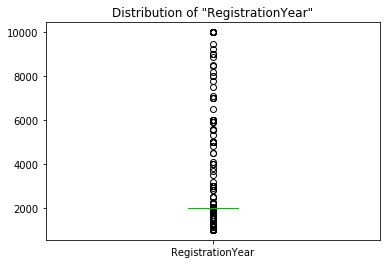

In [14]:
data['RegistrationYear'].plot(kind = 'box')
plt.title('Distribution of "RegistrationYear"')
plt.show()

It appears that there are plenty of 'outlier' values so this plot is not too helpful. Lets investigate the distribution of Registration Years on a histogram:

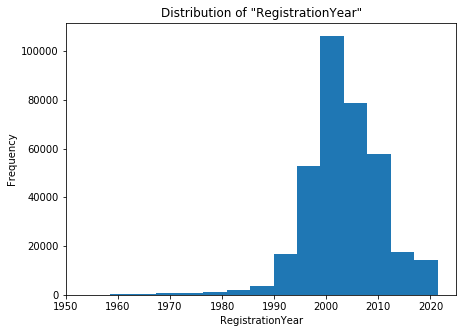

In [15]:
data['RegistrationYear'].plot(kind = 'hist', bins = 2000, xlim = (1950, 2025), figsize = (7,5))
plt.title('Distribution of "RegistrationYear"')
plt.xlabel('RegistrationYear')
plt.ylabel('Frequency')
plt.show()

We see the distribution from the plot.  We will remove the rows with 'RegistrationYear' year values below 1955 and greater than 2021.

In [16]:
data_mod = data.loc[((data['RegistrationYear'] >= 1955) & (data['RegistrationYear'] <= 2021)),:]
data_mod.shape

(353954, 12)

415 rows of data were successfully removed.

### Power

To now plot a histogram to see the distribution of the 'Power' valiable:

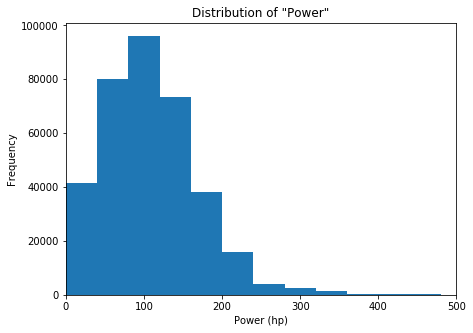

In [18]:
data_mod['Power'].plot(kind = 'hist', bins = 500, xlim = (0, 500), figsize = (7,5))
plt.title('Distribution of "Power"')
plt.xlabel('Power (hp)')
plt.ylabel('Frequency')
plt.show()

It seems that very few cars have power (hp) greater than 500.  From research, a Ferrari 812 has 789bhp and Lamborghini Aventador 740bhp, so will will use 790 as the cut off point and delete all rows with Power values > 790, assuming them to be errors:

In [19]:
data_mod = data_mod.loc[(data_mod['Power'] < 790),:]
data_mod.shape

(353626, 12)

A further 328 rows have been dropped.

### Registration Month

We now investigate the number of registrations in each month and plot this on a bar chart:

In [20]:
months = data_mod['RegistrationMonth'].value_counts().sort_index(ascending = True)
months

0     37071
1     23151
2     21228
3     34330
4     29233
5     29119
6     31451
7     27167
8     22607
9     23782
10    26074
11    24162
12    24251
Name: RegistrationMonth, dtype: int64

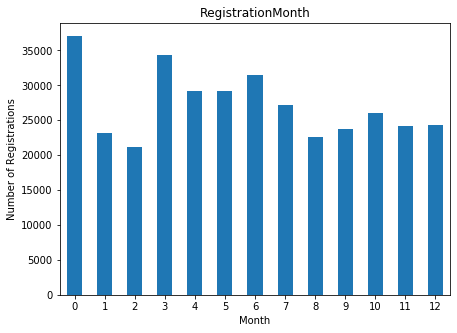

In [21]:
months.plot(kind = 'bar', figsize = (7,5), rot=0)
plt.title('RegistrationMonth')
plt.xlabel('Month')
plt.ylabel('Number of Registrations')
plt.show()

There is a problem with some of this data: the registration month for 37071 vehicles was incorrectly recorded as 0. 

We will remove these vehicles from the data:

In [22]:
data_mod = data_mod.loc[(data_mod['RegistrationMonth'] > 0),:]
data_mod.shape

(316555, 12)

### Number of Pictures

As stated above, we will drop this column as it contains no useful information.

In [23]:
data_mod = data_mod.drop(columns = ['NumberOfPictures'])
data_mod.shape

(316555, 11)

### Checking for Duplicates:

Now we check for duplicate rows in the dataset:

In [24]:
data_mod.duplicated().sum()

24942

In [25]:
100*data_mod.duplicated().sum()/len(data_mod)

7.879199507194643

There are many duplicated rows in this dataset in fact 7.88% of the rows are duplicated), so we need to remove them:

In [26]:
data_mod = data_mod.drop_duplicates()
data_mod.shape

(291613, 11)

The duplicated rows have been removed from the dataset.

In [27]:
data_mod

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


This initial pre-processing has resulted in a dataset with 291,613 rows and 11 columns.

### Categorical Variables

Now we will investigate further the six columns containing catagorical data:

In [28]:
categorical_data = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

For each of these columns we will investigate the number of unique values: 

In [29]:
for category in categorical_data:
    print(category)
    print('Number of Unique Values:', data_mod[category].value_counts().count())
    print()

VehicleType
Number of Unique Values: 9

Gearbox
Number of Unique Values: 3

Model
Number of Unique Values: 250

FuelType
Number of Unique Values: 8

Brand
Number of Unique Values: 40

NotRepaired
Number of Unique Values: 3



The 'Model' column has 250 unique values and the 'Brand' column has 40.  When using One Hot Encoding (OHE) to transform categorical variables to numeric ones, this would create 250 and 40 additional columns respectively. 

Therefore, in order to keep the models manageable, we will remove the 'Model' column from the data. If we had more information, we could potentially have created groups of car models to streamline the data, eg small, mid-size, SUV etc.  However, as we do not have this additional information currently, we will remove the column completely when using OHE.

This concludes the initial data investigation and preparation and we now move on to training the models:

## Model training

Before training, we need to encode the categorical variables. We shall compare two encoding techniques: One Hot Encoding (OHE) and Ordinal Encoding.

First we split the features from the target (price) and then divide the data into training, validation and test sets:

In [30]:
X = data_mod.drop(columns = ['Price'])
X.shape

(291613, 10)

In [31]:
y = data_mod['Price']
y.shape

(291613,)

### One Hot Encoding

As noted above, before we encoding using OHE, we will drop the 'Model' column, :

In [32]:
X_OHE = X.copy()
X_OHE = X_OHE.drop(columns = 'Model')
X_OHE.shape

(291613, 9)

Now we transform the remaining categorial features using OHE:

In [33]:
categorical_data_mod = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']

In [34]:
X_OHE = pd.get_dummies(X_OHE, columns=categorical_data_mod, drop_first = True)
X_OHE.shape

(291613, 62)

We now split the data. OHE is be applied before splitting the dataset into training, validation and test sets as otherwise it could lead to a mismatch in the number of columns in each set:

In [35]:
X_train_OHE, X_temp_OHE, y_train, y_temp = train_test_split(X_OHE, y, test_size=0.4, random_state=12345)
X_valid_OHE, X_test_OHE, y_valid, y_test = train_test_split(X_temp_OHE, y_temp, test_size=0.5, random_state=12345)
X_train_OHE.shape

(174967, 62)

In [36]:
X_valid_OHE.shape

(58323, 62)

In [37]:
X_test_OHE.shape

(58323, 62)

We now have the 3 datasets ready for training.

## Linear Regression

We will train two Linear Regression models: the first with the data encoded with OHE and the second with data encoded with Ordinal Encoding.

We will measure how long it takes to train the model and then how long to make predictions with it.  The quality of the model will be measured with the RMSE (Root Mean Squared Error).

In [38]:
start = timer()

lr_OHE_model = LinearRegression()
lr_OHE_model.fit(X_train_OHE, y_train)

end = timer()
time_lr_OHE_train = end - start
round(time_lr_OHE_train, 3)

2.001

We define a function to return the RMSE as follows:

In [39]:
def RMSE(target, predictions):
    MSE = mean_squared_error(target, predictions)
    RMSE = (MSE**0.5).round(2)
    return RMSE

Now we use the model to make predictions on the validation set:

In [40]:
start = timer()

valid_predictions_lr_OHE = lr_OHE_model.predict(X_valid_OHE)

end = timer()
time_lr_OHE_pred = end - start
round(time_lr_OHE_pred, 4)

0.1038

In [ ]:
And use the predictions generated to measure RMSE:

In [41]:
lr_OHE_RMSE = RMSE(y_valid, valid_predictions_lr_OHE)
lr_OHE_RMSE

2885.62

This is the standard deviation of the prediction errors (the square root of average squared errors between the actual and the predicted values of the 'Price'). 

We will now encode the data with Ordinal Encoding and compare the RMSE obtained. We will also use the dataset that excludes the 'model' column.

### Ordinal Encoding

When using Ordinal Encoding, we need to split the data first:

In [42]:
X_ord = X.copy()
X_ord = X_ord.drop(columns = 'Model')
X_ord.shape

(291613, 9)

In [43]:
X_train_ord, X_temp_ord, y_train, y_temp = train_test_split(X_ord, y, test_size=0.4, random_state=12345)
X_valid_ord, X_test_ord, y_valid, y_test = train_test_split(X_temp_ord, y_temp, test_size=0.5, random_state=12345)

In [44]:
X_train_ord.shape

(174967, 9)

We define OrdinalEncoder() as object and fit it only on the train set.  We then apply that encoder to the train, valid and test sets:

In [45]:
encoder = OrdinalEncoder()
encoder.fit(X_train_ord[categorical_data_mod])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [46]:
X_train_ord[categorical_data_mod] = encoder.transform(X_train_ord[categorical_data_mod])

In [47]:
X_train_ord[categorical_data_mod]

,VehicleType,Gearbox,FuelType,Brand,NotRepaired
191340,4.0,1.0,6.0,2.0,0.0
291728,5.0,1.0,6.0,30.0,0.0
175052,4.0,1.0,2.0,1.0,0.0
14292,4.0,1.0,2.0,20.0,0.0
169093,3.0,1.0,2.0,27.0,0.0
...,...,...,...,...,...
186539,0.0,1.0,2.0,38.0,0.0
54516,7.0,1.0,6.0,10.0,1.0
99591,8.0,1.0,6.0,31.0,2.0
88844,8.0,0.0,2.0,2.0,1.0


In [48]:
X_valid_ord[categorical_data_mod] = encoder.transform(X_valid_ord[categorical_data_mod])
X_test_ord[categorical_data_mod] = encoder.transform(X_test_ord[categorical_data_mod])

Now we train this second Linear Regression model:

In [49]:
start = timer()

lr_ord_model = LinearRegression()
lr_ord_model.fit(X_train_ord, y_train)

end = timer()
time_lr_ord_train = end - start
round(time_lr_ord_train, 3)

0.041

Now we make predictions on the validation set:

In [50]:
start = timer()

valid_predictions_lr_ord = lr_ord_model.predict(X_valid_ord)

end = timer()
time_lr_ord_pred = end - start
round(time_lr_ord_pred, 4)

0.006

And now we measure the RMSE on the validation set:

In [51]:
lr_ord_RMSE = RMSE(y_valid, valid_predictions_lr_ord)
lr_ord_RMSE

3124.33

The RMSE for the linear regression model trained with data coded with One Hot Encoding is smaller when compared to the model trained with data encoded with Ordinal Encoding. This is to be expected as Ordinal Encoding typically performs better with tree-based algorithms.

## Random Forest Regression

We will also train separate Random Forest Regression models using the data encoded with both One Hot Encoding and Ordinal Encoding.  We will tune these models using the n_estimators hyperparameter. 

We first train the data ecoded with OHE.

Having trained the model with all values of the n_estimators parameter from 1 to 41, only the following is presented to save on running time:

In [52]:
%%time

for estimator in range(37,40):
    model = RandomForestRegressor(random_state=12345, n_estimators=estimator)
    model.fit(X_train_OHE, y_train)
    valid_predictions = model.predict(X_valid_OHE)
    print('n_estimators =', estimator, '|', 'RMSE =', RMSE(y_valid, valid_predictions))

n_estimators = 37 | RMSE = 1856.83
n_estimators = 38 | RMSE = 1856.75
n_estimators = 39 | RMSE = 1856.97
CPU times: user 2min 8s, sys: 1.03 s, total: 2min 9s
Wall time: 2min 10s


The Random Forest Regression model (using data encoded with One Hot Encoding) with n_estimators = 38 has the lowest RMSE.  We will train this model:

In [53]:
start = timer()

rf_OHE_model = RandomForestRegressor(random_state=12345, n_estimators=19)
rf_OHE_model.fit(X_train_OHE, y_train)

end = timer()
time_rf_OHE_train = end - start
round(time_rf_OHE_train, 3)

22.351

Now we use it to make predictions:

In [54]:
start = timer()

valid_predictions_rf_OHE = rf_OHE_model.predict(X_valid_OHE)

end = timer()
time_rf_OHE_pred = end - start
round(time_rf_OHE_pred, 4)

0.5158

And now we measure the RMSE:

In [55]:
rf_OHE_RMSE = RMSE(y_valid, valid_predictions_rf_OHE)
rf_OHE_RMSE

1874.87

This is a significant improvement on the Linear Regression models.

To compare, we will now train a Random Forest Regression model using the data encoded with Ordinal Encoding.  We will again tune the n_estimators hyperparameter. 

(Note: Only a few loops of the for-loop are presented to save on model running time):

In [56]:
%%time

for estimator in range(46,50):
    model = RandomForestRegressor(random_state=12345, n_estimators=estimator)
    model.fit(X_train_ord, y_train)
    valid_predictions = model.predict(X_valid_ord)
    print('n_estimators =', estimator, '|', 'RMSE =', RMSE(y_valid, valid_predictions))

n_estimators = 46 | RMSE = 1863.68
n_estimators = 47 | RMSE = 1863.3
n_estimators = 48 | RMSE = 1863.24
n_estimators = 49 | RMSE = 1862.37
CPU times: user 1min 23s, sys: 114 ms, total: 1min 23s
Wall time: 1min 29s


We select the Random Forest Regression model (using data encoded with Ordinal Encoding) with n_estimators = 49

In [57]:
start = timer()

rf_ord_model = RandomForestRegressor(random_state=12345, n_estimators=49)
rf_ord_model.fit(X_train_ord, y_train)

end = timer()
time_rf_ord_train = end - start
round(time_rf_ord_train, 3)

22.569

In [58]:
start = timer()

valid_predictions_rf_ord = rf_ord_model.predict(X_valid_ord)

end = timer()
time_rf_ord_pred = end - start
round(time_rf_ord_pred, 4) 

1.1684

In [59]:
rf_ord_RMSE = RMSE(y_valid, valid_predictions_rf_ord)
rf_ord_RMSE

1862.37

The Random Forest Regression model with Ordinal Encoding does slightly better than the Random Forest Regression model with One Hot Encoding.

## Decision Tree Regression

We turn now to Decision Tree Regression models and we first train a model using OHE encoded data:

In [60]:
%%time

for depth in range(5,15):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(X_train_OHE, y_train)
    valid_predictions = model.predict(X_valid_OHE)
    print('max_depth =', depth, '|', 'RMSE =', RMSE(y_valid, valid_predictions))

max_depth = 5 | RMSE = 2543.27
max_depth = 6 | RMSE = 2410.67
max_depth = 7 | RMSE = 2306.11
max_depth = 8 | RMSE = 2230.62
max_depth = 9 | RMSE = 2168.97
max_depth = 10 | RMSE = 2127.2
max_depth = 11 | RMSE = 2088.9
max_depth = 12 | RMSE = 2067.27
max_depth = 13 | RMSE = 2065.79
max_depth = 14 | RMSE = 2076.99
CPU times: user 8.27 s, sys: 15.7 ms, total: 8.29 s
Wall time: 8.82 s


The Decision Tree Regression model (using data encoded with One Hot Encoding) with max_depth = 13 has the lowest RMSE.

We train this model:

In [61]:
start = timer()

dt_OHE_model = DecisionTreeRegressor(random_state=12345, max_depth=13)
dt_OHE_model.fit(X_train_OHE, y_train)

end = timer()
time_dt_OHE_train = end - start
round(time_dt_OHE_train, 3)

1.172

In [ ]:
We make predictions with this model:

In [62]:
start = timer()

valid_predictions_dt_OHE = dt_OHE_model.predict(X_valid_OHE)

end = timer()
time_dt_OHE_pred = end - start
round(time_dt_OHE_pred, 4) 

0.017

In [ ]:
And we mesure the RMSE of the predictions:

In [63]:
dt_OHE_RMSE = RMSE(y_valid, valid_predictions_dt_OHE)
dt_OHE_RMSE

2065.79

We now compare this to a Decision Tree Regression model trained using data encoded with Ordinal Encoding:

In [64]:
%%time

for depth in range(1,15):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(X_train_ord, y_train)
    valid_predictions = model.predict(X_valid_ord)
    print('max_depth =', depth, '|', 'RMSE =', RMSE(y_valid, valid_predictions))

max_depth = 1 | RMSE = 3803.18
max_depth = 2 | RMSE = 3318.03
max_depth = 3 | RMSE = 3033.14
max_depth = 4 | RMSE = 2735.59
max_depth = 5 | RMSE = 2538.41
max_depth = 6 | RMSE = 2398.39
max_depth = 7 | RMSE = 2281.8
max_depth = 8 | RMSE = 2203.86
max_depth = 9 | RMSE = 2137.81
max_depth = 10 | RMSE = 2108.04
max_depth = 11 | RMSE = 2082.48
max_depth = 12 | RMSE = 2086.53
max_depth = 13 | RMSE = 2082.61
max_depth = 14 | RMSE = 2128.76
CPU times: user 3.08 s, sys: 15.8 ms, total: 3.1 s
Wall time: 3.15 s


The Decision Tree Regression model (using data encoded with Ordinal Encoding) with max_depth = 11 has the lowest RMSE, so we use this one:

In [65]:
start = timer()

dt_ord_model = DecisionTreeRegressor(random_state=12345, max_depth=11)
dt_ord_model.fit(X_train_ord, y_train)

end = timer()
time_dt_ord_train = end - start
round(time_dt_ord_train, 3)

0.309

We now use it to make predictions:

In [66]:
start = timer()

valid_predictions_dt_ord = dt_ord_model.predict(X_valid_ord)

end = timer()
time_dt_ord_pred = end - start
round(time_dt_ord_pred, 4) 

0.0071

In [ ]:
And we measure the RMSE of the predictions:

In [67]:
dt_ord_RMSE = RMSE(y_valid, valid_predictions_dt_ord)
dt_ord_RMSE

2082.48

# Gradient Boosting Algorithms

We will now train models using 3 gradient boosting algorithms: LightGBM, XGBoost and Catboost. Gradient boosting combines 'boosting' and 'gradient descent'.  
    
Boosting utliises a group, or ensemble, of sequential models constructed from decision tree models. A single model may not perform well individually due to high variance or high bias. However, when they are aggregated, their combination reduces bias or variance. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models, ie gradient boosting algorithms train on the residual errors of the previous predictor.

First we will use LightGBM:

## LightGBM

LightGBM uses a 'leaf-wise algorithm' and controls model complexity by num_leaves (the maximum number of leaves each model has). Compared with depth-wise growth, this leaf-wise algorithm can converge much faster. However, it may over-fit if not used with the appropriate parameters.

We will train models using LGBMRegressor using the X_train_OHE dataset, the data coded with One Hot Encoding.  

We will first vary the num_leaves parameter as that is one of the most important parameters that controls the complexity of the LGBM model.  We will first set n_estimators=50 and learning_rate=0.1.

In [69]:
%%time

for leaves in range(300, 1300, 100):
    model = lgb.LGBMRegressor(num_leaves=leaves, learning_rate=0.1, n_estimators=50, max_depth=-1, seed = 12345)
    model.fit(X_train_OHE, y_train, verbose=5)
    y_pred = model.predict(X_valid_OHE)
    print('num_leaves =', leaves, '|', 'RMSE =', RMSE(y_valid, y_pred))

num_leaves = 300 | RMSE = 1754.41
num_leaves = 400 | RMSE = 1750.78
num_leaves = 500 | RMSE = 1743.81
num_leaves = 600 | RMSE = 1743.35
num_leaves = 700 | RMSE = 1742.53
num_leaves = 800 | RMSE = 1745.0
num_leaves = 900 | RMSE = 1742.59
num_leaves = 1000 | RMSE = 1745.38
num_leaves = 1100 | RMSE = 1746.43
num_leaves = 1200 | RMSE = 1745.95
CPU times: user 2min 16s, sys: 1.52 s, total: 2min 17s
Wall time: 2min 20s


We will now run the same analysis with n_estimators = 100:

In [70]:
%%time

for leaves in range(300, 1300, 100):
    model = lgb.LGBMRegressor(num_leaves=leaves, learning_rate=0.1, n_estimators=100, max_depth=-1, seed = 12345)
    model.fit(X_train_OHE, y_train, verbose=5)
    y_pred = model.predict(X_valid_OHE)
    print('num_leaves =', leaves, '|', 'RMSE =', RMSE(y_valid, y_pred))

num_leaves = 300 | RMSE = 1729.56
num_leaves = 400 | RMSE = 1732.25
num_leaves = 500 | RMSE = 1729.09
num_leaves = 600 | RMSE = 1731.24
num_leaves = 700 | RMSE = 1733.79
num_leaves = 800 | RMSE = 1738.24
num_leaves = 900 | RMSE = 1739.28
num_leaves = 1000 | RMSE = 1741.58
num_leaves = 1100 | RMSE = 1746.74
num_leaves = 1200 | RMSE = 1745.94
CPU times: user 4min 12s, sys: 2.54 s, total: 4min 14s
Wall time: 4min 19s


With n_estimators=100, the lowest RMSE is acheived when num_leaves = 500. We will now vary n_estimators further to see if we can reduce RMSE still further:

In [71]:
%%time

for estimator in range(50, 150, 10):
    model = lgb.LGBMRegressor(num_leaves=500, learning_rate=0.1, n_estimators=estimator, max_depth=-1, seed = 12345)
    model.fit(X_train_OHE, y_train, verbose=5)
    y_pred = model.predict(X_valid_OHE)
    print('n_estimators =', estimator, '|', 'RMSE =', RMSE(y_valid, y_pred))

n_estimators = 50 | RMSE = 1743.81
n_estimators = 60 | RMSE = 1736.34
n_estimators = 70 | RMSE = 1732.94
n_estimators = 80 | RMSE = 1730.85
n_estimators = 90 | RMSE = 1729.6
n_estimators = 100 | RMSE = 1729.09
n_estimators = 110 | RMSE = 1728.9
n_estimators = 120 | RMSE = 1729.02
n_estimators = 130 | RMSE = 1729.47
n_estimators = 140 | RMSE = 1730.14
CPU times: user 3min 2s, sys: 1.63 s, total: 3min 4s
Wall time: 3min 8s


In the analysis above, the model with num_leaves=500 and n_estimators = 110 has the lowest RMSE.

We now train the model using those hyperparameters:

In [72]:
start = timer()

LGBM_model = lgb.LGBMRegressor(num_leaves=500, learning_rate=0.1, n_estimators=110, max_depth=-1, seed = 12345)
LGBM_model.fit(X_train_OHE, y_train, verbose=5)

end = timer()
time_LGBM_train = end - start
round(time_LGBM_train, 3)

20.005

In [ ]:
No we make predictions on the validation set with that model:

In [73]:
start = timer()

valid_predictions_LGBM = LGBM_model.predict(X_valid_OHE)

end = timer()
time_LGBM_pred = end - start
round(time_LGBM_pred, 4) 

1.0976

In [ ]:
Now we calculate the RMSE:

In [74]:
LGBM_RMSE = RMSE(y_valid, valid_predictions_LGBM)
LGBM_RMSE

1728.9

We can plot the relative importance of the features:

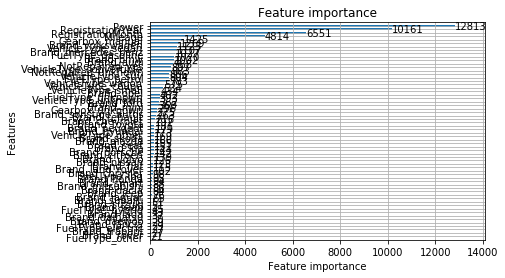

In [75]:
lgb.plot_importance(LGBM_model, height=0.5)
plt.rcParams['figure.figsize'] = [15, 15]
plt.yticks(fontsize=10)
plt.show()

In this model, Power, Registration Month and Registration year are the most important factors in determining the value of the car, followed by the mileage of the car.

## XGBoost

XGBoost (short for 'Extreme Gradient Boosting') is another popular gradient boosting library. It is an optimized distributed gradient boosting library and grows trees depth-wise. Model complexity is controlled by the max_depth hyperparameter. 

We will train the model on the data encoded with OHE and first optimise the n_estimator parameter:

In [77]:
%%time

for estimator in range(100, 200, 10):
    XGB_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = estimator)
    XGB_model.fit(X_train_OHE,y_train)
    y_pred = XGB_model.predict(X_valid_OHE)
    print('n_estimators =', estimator, '|', 'RMSE =', RMSE(y_valid, y_pred))

n_estimators = 100 | RMSE = 1923.14
n_estimators = 110 | RMSE = 1915.4
n_estimators = 120 | RMSE = 1901.55
n_estimators = 130 | RMSE = 1896.71
n_estimators = 140 | RMSE = 1891.89
n_estimators = 150 | RMSE = 1885.32
n_estimators = 160 | RMSE = 1880.5
n_estimators = 170 | RMSE = 1876.7
n_estimators = 180 | RMSE = 1870.47
n_estimators = 190 | RMSE = 1865.49
CPU times: user 3min 31s, sys: 134 ms, total: 3min 31s
Wall time: 3min 33s


In the above, the model with n_estimators = 190 had the lowest RMSE. By further increasing n_estimators, it appears this could be reduced further.

We will keep n_estimators at 190 and now see what effect varying max_depth has on the results:

In [78]:
%%time

for depth in range(9, 14):
    XGB_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = depth, alpha = 10, n_estimators = 190)
    XGB_model.fit(X_train_OHE,y_train)
    y_pred = XGB_model.predict(X_valid_OHE)
    print('max_depth =', depth, '|', 'RMSE =', RMSE(y_valid, y_pred))

max_depth = 9 | RMSE = 1760.15
max_depth = 10 | RMSE = 1751.62
max_depth = 11 | RMSE = 1744.09
max_depth = 12 | RMSE = 1742.98
max_depth = 13 | RMSE = 1743.98
CPU times: user 5min 44s, sys: 129 ms, total: 5min 44s
Wall time: 5min 46s


In [ ]:
We will run the model with max_depth = 13 and calculate the RMSE:

In [79]:
%%time

XGB_model1 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 13, alpha = 10, n_estimators = 190)
XGB_model1.fit(X_train_OHE,y_train)
valid_predictions_XBG1 = XGB_model1.predict(X_valid_OHE)
RMSE_XBG1 = RMSE(y_valid, valid_predictions_XBG1)
print('RMSE =', RMSE_XBG1)

RMSE = 1743.98
CPU times: user 1min 25s, sys: 81.6 ms, total: 1min 25s
Wall time: 1min 25s


We will now increase the colsample_bytree parameter to 0.4 to see what effect that has on the RMSE (we note however that high values can lead to overfitting)

In [80]:
start = timer()

XGB_model2 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.4, learning_rate = 0.1,
                max_depth = 13, alpha = 10, n_estimators = 190)
XGB_model2.fit(X_train_OHE,y_train)

end = timer()
time_XGB_model2_train = end - start
round(time_XGB_model2_train, 3)

106.263

In [81]:
start = timer()

valid_predictions_XBG2 = XGB_model2.predict(X_valid_OHE)

end = timer()
time_XGB_model2_pred = end - start
round(time_XGB_model2_pred, 4) 

1.7403

In [82]:
RMSE_XBG2 = RMSE(y_valid, valid_predictions_XBG2)
print('RMSE =', RMSE_XBG2)

RMSE = 1725.13


In [ ]:
We have managed to reduce the RMSE still further.

We now plot the relative importance of the features of this last model:

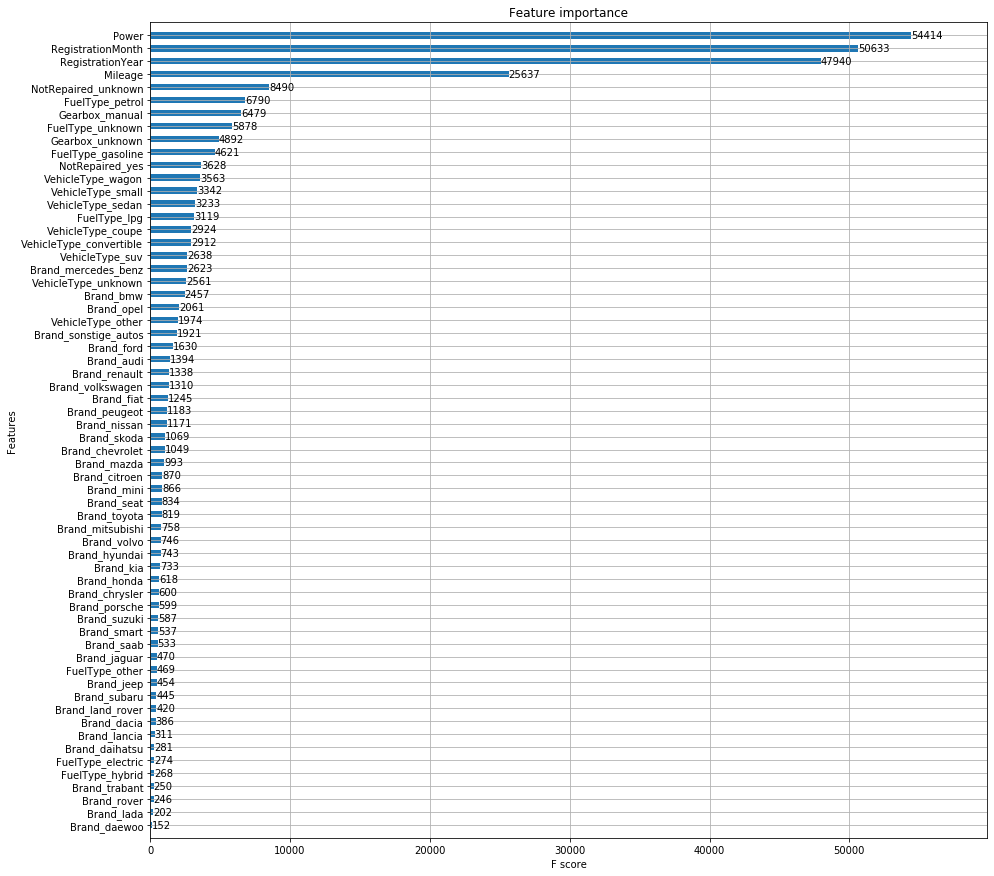

In [83]:
xgb.plot_importance(XGB_model2, height=0.5)
plt.rcParams['figure.figsize'] = [15, 15]
plt.yticks(fontsize=10)
plt.show()

In this model too are Power, Registration Month and Registration year the most important factors in determining the value of the car, followed by the mileage of the car.

## CatBoost 

CatBoost (categorical boosting) is also a gradient boosting library, but it differs from the other two above in that it can handle non-numeric values. That is, it applies various encoding techniques for categorical features so encoding does not need to be done separately in advance. So we need to use non-ended data.

In [85]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12345)
X_train.shape

(174967, 10)

We will first train the model with 50 iterations.  

We use the RMSE measure as the loss function because this is a regression task:

In [86]:
%%time

cb_model = cb.CatBoostRegressor(loss_function= 'RMSE', iterations=50)
categorical_data = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
cb_model.fit(X_train, y_train, cat_features=categorical_data, verbose=10)
valid_predictions_cb = cb_model.predict(X_valid)
RMSE_cb = RMSE(y_valid, valid_predictions_cb)
print('RMSE_cb =', RMSE_cb)

0:	learn: 4504.7408693	total: 233ms	remaining: 11.4s
10:	learn: 3788.9776333	total: 1.94s	remaining: 6.86s
20:	learn: 3292.7488094	total: 3.63s	remaining: 5.01s
30:	learn: 2956.4293223	total: 5.32s	remaining: 3.26s
40:	learn: 2710.3218430	total: 7.01s	remaining: 1.54s
49:	learn: 2542.8391416	total: 8.43s	remaining: 0us
RMSE_cb = 2523.92
CPU times: user 8.26 s, sys: 843 ms, total: 9.1 s
Wall time: 9.99 s


We will now attempt to improve on this RMSE by increasing the number of iterations to 500:

In [87]:
start = timer()

cb_model2 = cb.CatBoostRegressor(loss_function= 'RMSE', iterations=500)
categorical_data = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
cb_model2.fit(X_train, y_train, cat_features=categorical_data, verbose=50)

end = timer()
time_cb_model2_train = end - start
round(time_cb_model2_train, 3)

0:	learn: 4503.4082424	total: 400ms	remaining: 3m 19s
50:	learn: 2497.1381805	total: 19s	remaining: 2m 47s
100:	learn: 2100.8039529	total: 36s	remaining: 2m 22s
150:	learn: 1997.7589574	total: 53.6s	remaining: 2m 3s
200:	learn: 1948.6648601	total: 1m 11s	remaining: 1m 46s
250:	learn: 1916.3574733	total: 1m 28s	remaining: 1m 28s
300:	learn: 1888.4768057	total: 1m 45s	remaining: 1m 9s
350:	learn: 1869.3517792	total: 2m 3s	remaining: 52.4s
400:	learn: 1852.5267722	total: 2m 21s	remaining: 35s
450:	learn: 1837.3031744	total: 2m 39s	remaining: 17.4s
499:	learn: 1824.3965304	total: 2m 57s	remaining: 0us


179.747

Increasing the number of iterations has had the desired effect; RMSE on the training set has decreased.

We now use this second model to make predictions:

In [88]:
start = timer()

valid_predictions_cb2 = cb_model2.predict(X_valid)

end = timer()
time_cb_model2_pred = end - start
round(time_cb_model2_pred, 4) 

0.2103

And we measure the RMSE on these predictions:

In [89]:
RMSE_cb2 = RMSE(y_valid, valid_predictions_cb2)
print('RMSE =', RMSE_cb2)

RMSE = 1809.47


It appears that we could potentially even decrease the RMSE still further by increasing the number of iterations.

We plot the importance of the features:

In [90]:
from catboost import Pool

In [91]:
train_pool = cb_model2.get_feature_importance(Pool(X_train, y_train, cat_features=categorical_data))
train_pool

array([11.5214495 , 37.41470471,  0.47064706, 22.60852609,  3.6820735 ,
       11.50253672,  0.09316126,  1.80633104,  7.78540329,  3.11516684])

In [92]:
X_train.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Mileage', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

In [93]:
catboost_df = pd.DataFrame({'feature_names': X_train.columns, 'feature_importance': train_pool}).sort_values(by=['feature_importance'])
catboost_df

,feature_names,feature_importance
6,RegistrationMonth,0.093161
2,Gearbox,0.470647
7,FuelType,1.806331
9,NotRepaired,3.115167
4,Model,3.682073
8,Brand,7.785403
5,Mileage,11.502537
0,VehicleType,11.521450
3,Power,22.608526
1,RegistrationYear,37.414705


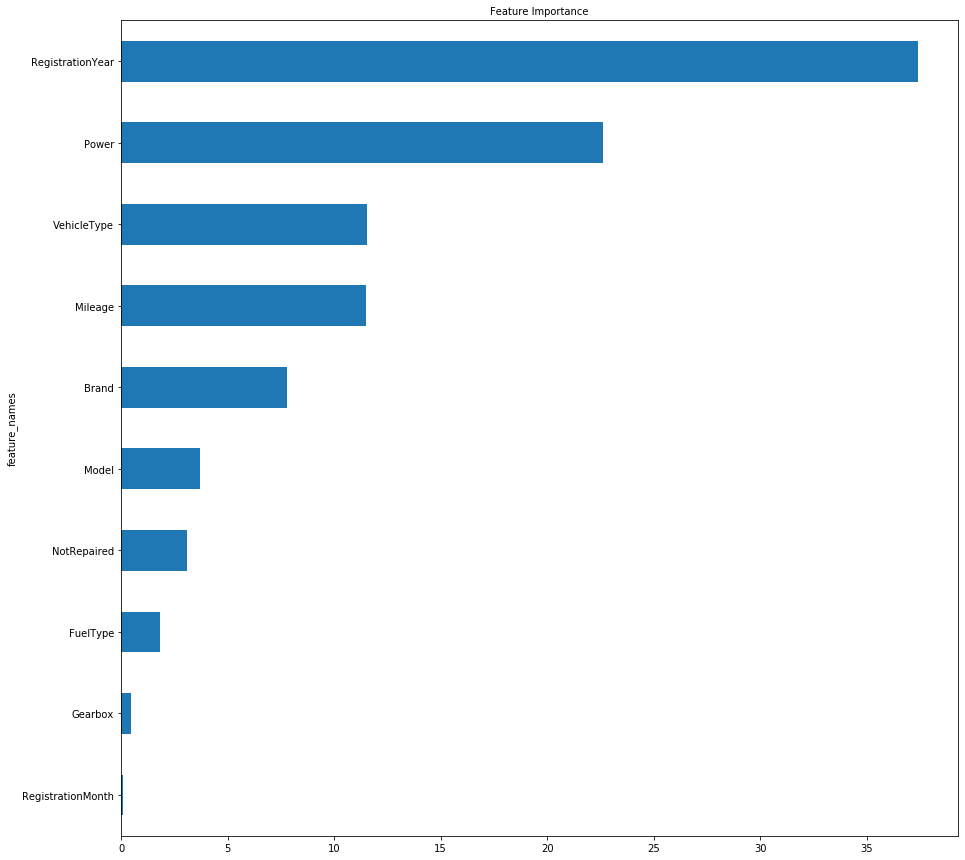

In [94]:
catboost_df.plot(kind = 'barh', x='feature_names', y='feature_importance', legend=None, fontsize=10)
plt.title('Feature Importance', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('')
plt.show()

In [ ]:
In this model, 'Registration Year' is the mosr important feature, followed by 'Power'.

## Summary and Model Comparison

### Quality of Predictions (Validation Set)

The following is a summary of the RMSE metrics obtained from the various models we have trained and tuned on the validation dataset:

In [95]:
columns = ['Model', 'RMSE for One Hot Encoding', 'RMSE for Ordinal Encoding', 'RMSE with no encoding']

In [96]:
lr = ['Linear Regression', lr_OHE_RMSE, lr_ord_RMSE, '']
rf = ['Random Forest Regression', rf_OHE_RMSE, rf_ord_RMSE, '']
dt = ['Decision Tree Regression', dt_OHE_RMSE, dt_ord_RMSE, '']
lgbm = ['LGBM Regression', LGBM_RMSE, '', '']
xgb = ['XGBoost Regression', RMSE_XBG2, '', '']
cb = ['Catboost Regression', '', '', RMSE_cb2]

In [97]:
RMSE_validation = pd.DataFrame([lr, rf, dt, lgbm, xgb, cb], columns=list(columns))
RMSE_validation

,Model,RMSE for One Hot Encoding,RMSE for Ordinal Encoding,RMSE with no encoding
0,Linear Regression,2885.62,3124.33,
1,Random Forest Regression,1874.87,1862.37,
2,Decision Tree Regression,2065.79,2082.48,
3,LGBM Regression,1728.9,,
4,XGBoost Regression,1725.13,,
5,Catboost Regression,,,1809.47


The XGBoost model had the lowest RMSE for the validation data, closely followed by the LGBM model.

### Time Required for Training and Speed of Predictions (measured in seconds)

We now build a table to show the training times and speed of prediction for the various models:

In [98]:
columns_time = ['Model', 'Training Time (OHE)', 'Training Time (Ordinal)', 'Training Time (No Encoding)', 'Speed of Prediction (OHE)', 'Speed of Prediction (Ordinal)', 'Speed of Prediction (No Encoding)']

In [99]:
lr_time = ['Linear Regression', time_lr_OHE_train, time_lr_ord_train, '',time_lr_OHE_pred, time_lr_ord_pred, '']
rf_time = ['Random Forest Regression', time_rf_OHE_train, time_rf_ord_train, '',time_rf_OHE_pred, time_rf_ord_pred, '']
dt_time = ['Decision Tree Regression', time_dt_OHE_train, time_dt_ord_train, '',time_dt_OHE_pred, time_dt_ord_pred, '']
lgbm_time = ['LGBM Regression', time_LGBM_train, '', '', time_LGBM_pred,'','']
xgb_time = ['XGBoost Regression', time_XGB_model2_train, '', '',time_XGB_model2_pred,'', '']
cb_time = ['Catboost Regression', '', '', time_cb_model2_train, '', '', time_cb_model2_pred]

In [100]:
Timings = pd.DataFrame([lr_time, rf_time, dt_time, lgbm_time, xgb_time, cb_time], columns=list(columns_time))
Timings

,Model,Training Time (OHE),Training Time (Ordinal),Training Time (No Encoding),Speed of Prediction (OHE),Speed of Prediction (Ordinal),Speed of Prediction (No Encoding)
0,Linear Regression,2.00071,0.0413313,,0.103835,0.00601013,
1,Random Forest Regression,22.3513,22.569,,0.515764,1.16837,
2,Decision Tree Regression,1.17214,0.308695,,0.0170165,0.00713868,
3,LGBM Regression,20.0046,,,1.09761,,
4,XGBoost Regression,106.263,,,1.74032,,
5,Catboost Regression,,,179.747,,,0.210254


### Quality of Predictions (Test Set)

Finally, we will run the models on the test set data and again compare the RMSEs obtained:

In [101]:
test_predictions_lr_OHE = lr_OHE_model.predict(X_test_OHE)
test_predictions_lr_ord = lr_ord_model.predict(X_test_ord)
test_predictions_rf_OHE = rf_OHE_model.predict(X_test_OHE)
test_predictions_rf_ord = rf_ord_model.predict(X_test_ord)
test_predictions_dt_OHE = dt_OHE_model.predict(X_test_OHE)
test_predictions_dt_ord = dt_ord_model.predict(X_test_ord)
test_predictions_LGBM = LGBM_model.predict(X_test_OHE)
test_predictions_XBG2 = XGB_model2.predict(X_test_OHE)
test_predictions_cb2 = cb_model2.predict(X_test)

In [102]:
lr_t = ['Linear Regression', RMSE(y_test, test_predictions_lr_OHE), RMSE(y_test, test_predictions_lr_ord), '']
rf_t = ['Random Forest Regression', RMSE(y_test, test_predictions_rf_OHE), RMSE(y_test, test_predictions_rf_ord), '']
dt_t = ['Decision Tree Regression', RMSE(y_test, test_predictions_dt_OHE), RMSE(y_test, test_predictions_dt_ord), '']
lgbm_t = ['LGBM Regression', RMSE(y_test, test_predictions_LGBM), '', '']
xgb_t = ['XGBoost Regression', RMSE(y_test, test_predictions_XBG2), '', '']
cb_t = ['Catboost Regression', '', '', RMSE(y_test, test_predictions_cb2)]

In [103]:
RMSE_testing = pd.DataFrame([lr_t, rf_t, dt_t, lgbm_t, xgb_t, cb_t], columns=list(columns))
RMSE_testing

,Model,RMSE for One Hot Encoding,RMSE for Ordinal Encoding,RMSE with no encoding
0,Linear Regression,2890.96,3133.91,
1,Random Forest Regression,1900.65,1897.43,
2,Decision Tree Regression,2099.34,2117.91,
3,LGBM Regression,1760.97,,
4,XGBoost Regression,1756.28,,
5,Catboost Regression,,,1841.7


### Conclusions

1. <u>Quality of the models</u>

The RMSE of Predictions on the test set data are very similar for the XGBoost and Catboost Regression models, with LGBM close behind.  It is possible that with further tuning of the Catboost model parameters, accuracy could be further improved.  All three of these gradient boosting models significantly outperform models that do not employ gradient boosting. 


2. <u>Speed of the models for training and predicting</u>

The Catboost model took the longest to train at 180 seconds, followed by XGBoost at 106. The Random Forest took 22 seconds, but tuning the hyperparameters took much longer. 

Catboost had a much faster speed of prediction than both XGBoost and LGBM.


3. <u>Feature importance</u>

For the LGBM model, Power is the most important feature followed by Registration Year and then some way behind that is Registration Month. 
For the XGBoost model, Power is the most important feature, followed by Registration month and Registration year which are both similar in importance.
For the Catboost model, Registration Year is the most important feature, followed by 'Power'. Registration month has almost no importance at all. 